In [1]:
import numpy as np
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import estimator as est
rng = np.random.default_rng(seed=315)
import skewer_computations as skc
from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
from lace.cosmo import camb_cosmo
from forestflow import pcross
from scipy.interpolate import interp1d

import mask_calculations as mc


Load the data

In [2]:
# set sim_name
sim_name='sim_pair_30' # other version will be 'diffSeed'
sim_dir='central'
snap_num = 6
# set phase
phase = "sim_minus"
# set axis number
axis = 1

In [3]:
from astropy.cosmology import Planck15 as p15, z_at_value
import astropy.units as u
p15.comoving_distance(2)

<Quantity 5311.53854793 Mpc>

In [4]:
# load the skewers x 
meas_path = "/Users/mlokken/research/lyman_alpha/data/"
delta_x = np.load(meas_path+"snap_{:d}/delta_x/skewers_6_psim_minus_ax1_Ns768_wM0.05_sT1.0_sg1.0.npz".format(snap_num))
delta_flux_x = delta_x['delta_flux_x'] # these are already normalized
Np = delta_flux_x.shape[1]
L = delta_x['L_Mpc']
pix_spacing = L/Np
print("pixel spacing is", pix_spacing, "Mpc")
# xpar = delta_x['xpar'] # this is still wrong for some reason, redefined below
delta_x.close()
xpar = np.arange(0, L, pix_spacing)+pix_spacing/2.



pixel spacing is 0.05 Mpc


In [5]:
nskew = delta_flux_x.shape[0]
nside = np.sqrt(nskew).astype(int)
print(f"Box is {L} Mpc per side with {nside} skewers per side")
print(f"Spacing between pixels along line-of-sight = {pix_spacing} Mpc")

# bin delta_flux along line-of-sight
binsize = 10
if Np%binsize != 0:
    print("Np is not divisible by binsize")
    sys.exit()
delta_flux_b, xpar_b = est.bin_spectra(delta_flux_x, xpar, binsize)
Np_b=delta_flux_b.shape[1]
pix_spacing_b = xpar_b[1]-xpar_b[0]
print(f"Spacing between pixels along line-of-sight after binning = {pix_spacing_b} Mpc")
delta_flux_k = np.fft.rfft(delta_flux_b)*np.sqrt(pix_spacing_b/Np_b)
Nk = delta_flux_k.shape[1]
# get the positions
xpos = np.linspace(0,L,nside)
ypos = np.linspace(0,L,nside)
print("spacing between neighboring skewers is {:.2f} Mpc".format(xpos[1]-xpos[0]))
positions = np.array([[x,y] for x in xpos for y in ypos])
subsel=False
nsub=5000
if subsel:
    randoms = rng.choice(len(positions), size=nsub)
    sel = np.zeros(len(positions), dtype=bool)
    sel[randoms] = True
else:
    sel = np.ones(len(positions), dtype=bool)
positions_sel = np.copy(positions)
positions_sel[~sel] = np.nan
delta_flux_x[~sel] = np.nan
delta_flux_b[~sel] = np.nan
delta_flux_k[~sel] = np.nan

# make masked arrays
delta_flux_x = np.ma.masked_invalid(delta_flux_x)
delta_flux_b = np.ma.masked_invalid(delta_flux_b)
delta_flux_k = np.ma.masked_invalid(delta_flux_k)
positions_sel = np.ma.masked_invalid(positions_sel)

# reshape into a grid
delta_flux_x_grid = np.reshape(delta_flux_x, (int(nside), int(nside), Np))
delta_flux_b_grid = np.reshape(delta_flux_b, (int(nside), int(nside), Np_b))
delta_flux_k_grid = np.reshape(delta_flux_k, (int(nside), int(nside), Nk))
position_grid = np.reshape(positions_sel, (int(nside), int(nside), 2))

delta_x_matrix_binned = est.make_delta_x_matrix(L, Np_b, xpar_b)

Box is 67.5 Mpc per side with 768 skewers per side
Spacing between pixels along line-of-sight = 0.05 Mpc
Number of bins: 135
Spacing between pixels along line-of-sight after binning = 0.49999999999999994 Mpc
spacing between neighboring skewers is 0.09 Mpc


In [6]:
# match the total number of pixels masked to what is necessary for the skyline version
skyline_width = 2
Npmasked_total = skyline_width * nskew
Npm_per_skew = skyline_width

In [44]:
# in the subselected forest, do some masking schemes along the line-of-sight axis
# 1: random masking of 1-5 pixels in each skewer for every line of sight
print("Doing random masking")
delta_flux_randmasked_b_grid = np.ma.MaskedArray.copy(delta_flux_b_grid)
random_mask = np.ones((nside, nside, Np_b)) # store the mask

masklocs_per_skewer = []
nmasked_rand = 0
for i in range(nside):
    for j in range(nside):
        nmask = rng.integers(Npm_per_skew-2, Npm_per_skew+3) # average # of pixels masked will be Npm_per_skew
        if nmask != 0:
            masklocs = rng.choice(np.arange(Np_b), size=nmask, replace=False)
            masklocs_per_skewer.append(masklocs)
            delta_flux_randmasked_b_grid[i, j, masklocs] = 0
            nmasked_rand += nmask
            random_mask[i,j, masklocs] = 0


print("Total number of pixels masked in random scheme is", nmasked_rand/Npmasked_total*100, "percent of the total desired")

# 2: 'skyline-like' masking: mask a range of N pixels 1/x of the way through the box
print("Doing single-skyline masking")
skyline_width = 2
boxdiv = 4
sky_maskrange = np.arange(Np_b//boxdiv, Np_b//boxdiv+skyline_width)
delta_flux_skyline_b_grid = np.ma.MaskedArray.copy(delta_flux_b_grid)
delta_flux_skyline_b_grid[:, :, sky_maskrange] = 0
nmasked_skyline = skyline_width*nskew
print("total number of pixels masked in skyline scheme is", nmasked_skyline/Npmasked_total*100, "percent of the total desired")
skyline_mask = np.ones((nside, nside, Np_b)) # store the mask
skyline_mask[:, :, sky_maskrange] = 0

# 3: put a DLA-like mask (20 pixels at once) at random positions
print("Doing DLA masking")
dla_width = 10
ndla = int(Npmasked_total // dla_width)
nmasked_dla = 0
dla_mask = np.ones((nside, nside, Np_b)) # store the mask
# get all indices
dla_locs_xx, dla_locs_yy = np.indices((nside, nside))
if ndla!=nside**2:
    dla_locs_xx = rng.choice(dla_locs_xx.ravel(), size=ndla, replace=False)
    dla_locs_yy = rng.choice(dla_locs_yy.ravel(), size=ndla, replace=False)
else:
    dla_locs_xx = dla_locs_xx.ravel()
    dla_locs_yy = dla_locs_yy.ravel()
dla_locs_zstart = rng.choice(np.arange(Np_b-dla_width), size=ndla, replace=True)
delta_flux_dla_b_grid = np.ma.MaskedArray.copy(delta_flux_b_grid)
for i in range(ndla):
    z_start = dla_locs_zstart[i]
    z_end  = z_start + dla_width
    delta_flux_dla_b_grid[dla_locs_xx[i], dla_locs_yy[i], z_start:z_end] = 0
    nmasked_dla += dla_width
    dla_mask[dla_locs_xx[i], dla_locs_yy[i], z_start:z_end] = 0
print("total number of pixels masked in DLA scheme is", nmasked_dla/Npmasked_total*100, "percent of the total desired")

#4: double skyline-like masking: mask 1 pixel 1/x of the way through the box and another pixel 1/x+2 of the way through the box
print("Doing double-skyline masking")
double_skyline_width = 1
double_skyline_distance = 2
double_sky_maskrange = np.arange(int(Np_b//boxdiv), int(Np_b//boxdiv)+double_skyline_width)
delta_flux_2skyline_b_grid = np.ma.MaskedArray.copy(delta_flux_b_grid)
delta_flux_2skyline_b_grid[:, :, double_sky_maskrange] = 0
delta_flux_2skyline_b_grid[:, :, double_sky_maskrange+double_skyline_distance] = 0
nmasked_2skyline = double_skyline_width*2*nskew

skyline_2mask = np.ones((nside, nside, Np_b)) # store the mask
skyline_2mask[:, :, double_sky_maskrange] = 0
skyline_2mask[:, :, double_sky_maskrange+double_skyline_distance] = 0

Doing random masking
Total number of pixels masked in random scheme is 100.07892184787326 percent of the total desired
Doing single-skyline masking
total number of pixels masked in skyline scheme is 100.0 percent of the total desired
Doing DLA masking
total number of pixels masked in DLA scheme is 99.99932183159721 percent of the total desired
Doing double-skyline masking


In [45]:
# make sure all the masks have very similar sum
Npunmasked_total = nskew*Np_b-Npmasked_total
print ("Fraction of desired skewers masked in random, skyline, dla, and 2 skyline cases", print(np.sum(random_mask)/Npunmasked_total, np.sum(skyline_mask)/Npunmasked_total, np.sum(dla_mask)/Npunmasked_total, np.sum(skyline_2mask)/Npunmasked_total))

0.9999881320529513 1.0 1.0001128156083567 1.0
Fraction of desired skewers masked in random, skyline, dla, and 2 skyline cases None


In [46]:
pad = True
if pad:
    # incorporate the larger mask (zero padding, ish) if desired
    delta_flux_b_grid, padmask_og = mc.skewer_offset_and_pad(delta_flux_b_grid, rng)
    delta_flux_randmasked_b_grid, padmask_rand = mc.skewer_offset_and_pad(delta_flux_randmasked_b_grid, rng)
    delta_flux_skyline_b_grid, padmask_skyline = mc.skewer_offset_and_pad(delta_flux_skyline_b_grid, rng)
    delta_flux_dla_b_grid, padmask_dla = mc.skewer_offset_and_pad(delta_flux_dla_b_grid, rng)
    delta_flux_2skyline_b_grid, padmask_2skyline = mc.skewer_offset_and_pad(delta_flux_2skyline_b_grid, rng)


In [47]:
# # check a few spectra in each
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# for i in range(3):
#     j=0
#     ax[i].plot(delta_flux_b_grid_r[i, i, :], label='original')
#     ax[i].plot(delta_flux_randmasked_b_grid_r[i, i, :], label='random')
#     ax[i].plot(delta_flux_skyline_b_grid_r[i, i, :], label='skyline')
#     ax[i].plot(delta_flux_dla_b_grid_r[i, i, :], label='dla')
#     ax[i].plot(delta_flux_2skyline_b_grid_r[i, i, :], label='2skyline')
#     ax[i].legend()

In [69]:
# FFT the masks
if pad:
    skyline_mask_k = np.fft.rfft(skyline_mask*padmask_skyline, axis=2)
    skyline_2mask_k = np.fft.rfft(skyline_2mask*padmask_2skyline, axis=2)
    dla_mask_k = np.fft.rfft(dla_mask*padmask_dla, axis=2)
    random_mask_k = np.fft.rfft(random_mask*padmask_rand, axis=2)
else:
    skyline_mask_k = np.fft.rfft(skyline_mask, axis=2)
    skyline_2mask_k = np.fft.rfft(skyline_2mask, axis=2)
    dla_mask_k = np.fft.rfft(dla_mask, axis=2)
    random_mask_k = np.fft.rfft(random_mask, axis=2)

In [49]:
# now recompute the delta_ks for the masked skewers
delta_flux_randmasked_k_grid = np.ma.masked_invalid(np.fft.rfft(delta_flux_randmasked_b_grid, axis=2)*np.sqrt(pix_spacing_b/Np_b))
# delete the pixel-space arrays to save memory
del delta_flux_randmasked_b_grid
delta_flux_skyline_k_grid = np.ma.masked_invalid(np.fft.rfft(delta_flux_skyline_b_grid, axis=2)*np.sqrt(pix_spacing_b/Np_b))
del delta_flux_skyline_b_grid
delta_flux_dla_k_grid = np.ma.masked_invalid(np.fft.rfft(delta_flux_dla_b_grid, axis=2)*np.sqrt(pix_spacing_b/Np_b))
del delta_flux_dla_b_grid
delta_flux_2skyline_k_grid = np.ma.masked_invalid(np.fft.rfft(delta_flux_2skyline_b_grid, axis=2)*np.sqrt(pix_spacing_b/Np_b))
del delta_flux_2skyline_b_grid
delta_flux_k_padded_grid = np.ma.masked_invalid(np.fft.rfft(delta_flux_b_grid, axis=2)*np.sqrt(pix_spacing_b/Np_b))

# reshape the masked arrays into 2D arrays
delta_flux_randmasked_k = np.reshape(delta_flux_randmasked_k_grid, (nskew, Nk))
delta_flux_skyline_k = np.reshape(delta_flux_skyline_k_grid, (nskew, Nk))
delta_flux_dla_k = np.reshape(delta_flux_dla_k_grid, (nskew, Nk))
delta_flux_2skyline_k = np.reshape(delta_flux_2skyline_k_grid, (nskew, Nk))
delta_flux_k_padded = np.reshape(delta_flux_k_padded_grid, (nskew, Nk))

In [50]:
kpar_b = np.fft.rfftfreq(Np_b, pix_spacing_b)*2*np.pi # frequency in Mpc^-1
kmax = np.pi/pix_spacing_b
kbin_spacing = kpar_b[1]-kpar_b[0]

# make a set of bins with kpar_b as centers
kbin_est = np.array([[kp-(kpar_b[1]-kpar_b[0])/2, kp+(kpar_b[1]-kpar_b[0])/2] for kp in kpar_b])
Nbin = len(kbin_est)

In [17]:
# # plot the deltas of the DLA masked skewers vs the originals
# plt.figure()
# # i = 90
# i = 0
# for j in range(100):
#     # plt.plot(xpar_b, delta_flux_b_grid[i, i], label='original')
#     # plt.plot(xpar_b, delta_flux_dla_b_grid[i, i], label='DLA masked')
#     # plt.plot(xpar_b, delta_flux_2skyline_b_grid[i, i], label='2 skylines masked')
#     plt.plot(xpar_b, delta_flux_dla_b_grid.real[i, j]-delta_flux_b_grid.real[i, j], label='DLA masked')

#     # plt.plot(xpar_b, delta_flux_randmasked_b_grid.real[i, i]-delta_flux_b_grid.real[i, i], label='random masked')
#     # plt.plot(xpar_b, delta_flux_2skyline_b_grid[i, i]-delta_flux_b_grid[i,i], label='2 skylines masked')
#     plt.plot(xpar_b, delta_flux_skyline_b_grid.real[i, j]-delta_flux_b_grid.real[i,j], label='1 skylines masked')
#     plt.ylim([-.5,.3])
#     plt.legend()
#     plt.show()
#     plt.clf()

    # # plot the delta flux k
    # plt.plot(kpar_b,delta_flux_k_grid[i,j], label='original')
    # plt.plot(kpar_b,delta_flux_randmasked_k_grid[i,j], label='random masked')
    # plt.plot(kpar_b,delta_flux_skyline_k_grid[i,j], label='skyline masked')
    # plt.plot(kpar_b,delta_flux_dla_k_grid[i,j], label='DLA masked')
    # plt.plot(kpar_b,delta_flux_2skyline_k_flat[i,j], label='double skyline masked')
    # plt.legend()
    # plt.show()
    # plt.clf()

IndexError: list index out of range

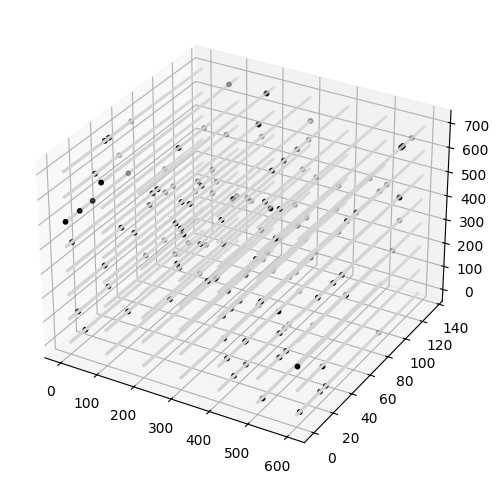

In [18]:
# visualize the masks
cm = plt.cm.jet
# 1: plot a 3D cube showing the masked pixel locations
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(0, nside, 100):
    for j in range(0, nside, 100): # only plot every 10th column
        # get a random color for this line of pixels
        color = cm((counter*10)%100)
        if counter<300:
            masklocs = masklocs_per_skewer[i*nside+j]
            # plot a line of light grey pixels
            ax.scatter(i*np.ones(Np_b), np.arange(Np_b), j*np.ones(Np_b), c='lightgrey', s=2)
            # fill in the masked pixels for this line with black
            ax.scatter(i*np.ones(len(masklocs)), masklocs, j*np.ones(len(masklocs)), c='k', s=10)
            counter +=1
        else:
            break
ax.set_xlabel('x')
ax.set_ylabel('pixels')
ax.set_zlabel('y')
plt.title("Random masking of 1-5 pixels in each skewer")

IndexError: list index out of range

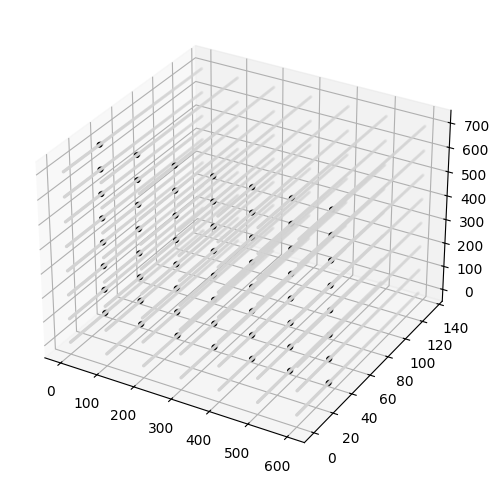

In [19]:
# 2: skyline visualization

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(0, nside, 100):
    for j in range(0, nside, 100): # only plot every 10th column
        # get a random color for this line of pixels
        color = cm((counter*10)%100)
        if counter<300:
            masklocs = masklocs_per_skewer[i*nside+j]
            # plot a line of light grey pixels
            ax.scatter(i*np.ones(Np_b), np.arange(Np_b), j*np.ones(Np_b), c='lightgrey', s=2, zorder=counter)
            # fill in the masked pixels for this line with black
            ax.scatter(i*np.ones(skyline_width), sky_maskrange, j*np.ones(skyline_width), c='k', s=10, zorder=counter+1)
            counter +=1
        else:
            break
ax.set_xlabel('x')
ax.set_ylabel('pixels')
ax.set_zlabel('y')
plt.title("Skyline-like masking")

Text(0.5, 0.92, 'DLA-like masking')

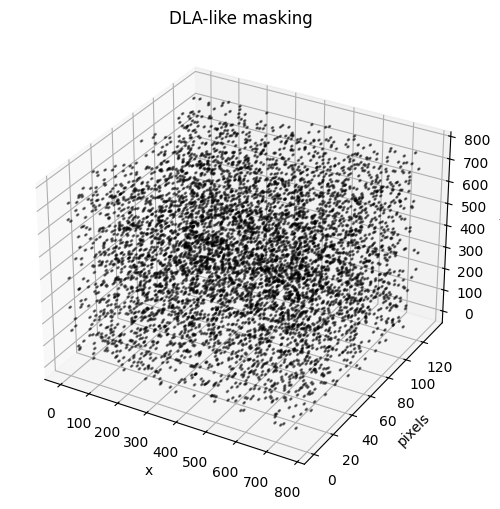

In [23]:
# 3: the DLA_like mask

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111, projection='3d')

for c, dlax in enumerate(dla_locs_xx[::100]):
    dlay = dla_locs_yy[::100][c]
    ax.scatter(dlax*np.ones(dla_width), dla_locs_zstart[c]+np.arange(dla_width), dlay*np.ones(dla_width), c='k', alpha=.4, s=1)

ax.set_xlabel('x')
ax.set_ylabel('pixels')
ax.set_zlabel('y')
plt.title("DLA-like masking")

Text(0.5, 0.92, 'Double-skyline-like masking')

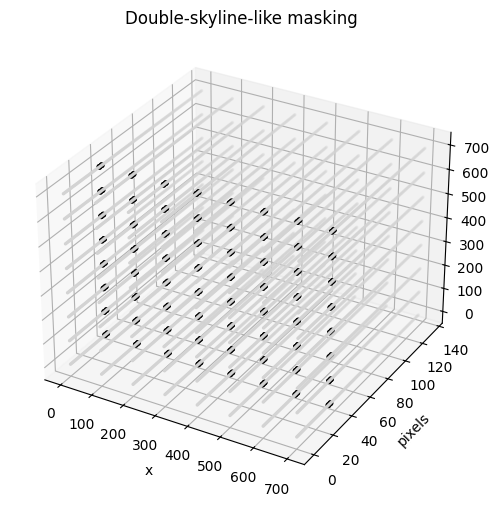

In [ ]:
# 4: double-skyline visualization

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111, projection='3d')
counter = 0
for i in range(0, nside, 100):
    for j in range(0, nside, 100): # only plot every 10th column
        # get a random color for this line of pixels
        color = cm((counter*10)%100)
        if counter<300:
            masklocs = masklocs_per_skewer[i*nside+j]
            # plot a line of light grey pixels
            ax.scatter(i*np.ones(Np_b), np.arange(Np_b), j*np.ones(Np_b), c='lightgrey', s=2, zorder=counter)
            # fill in the masked pixels for this line with black
            ax.scatter(i*np.ones(skyline_width), double_sky_maskrange, j*np.ones(double_skyline_width), c='k', s=10, zorder=counter+1)
            ax.scatter(i*np.ones(skyline_width), double_sky_maskrange+double_skyline_distance, j*np.ones(double_skyline_width), c='k', s=10, zorder=counter+1)
            counter +=1
        else:
            break
ax.set_xlabel('x')
ax.set_ylabel('pixels')
ax.set_zlabel('y')
plt.title("Double-skyline-like masking")

Load the model

In [33]:
# get the model

path_program = "/Users/mlokken/research/lyman_alpha/software/ForestFlow/"

folder_lya_data = path_program + "data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program[:-1],
    folder_data=folder_lya_data,
    force_recompute_plin=False,
    average="both",
)

In [34]:
# read the model
central = Archive3D.get_testing_data("mpg_central")
zs = np.array([central[snap_num]['z']]) 

k3d_Mpc = central[snap_num]['k3d_Mpc']
mu3d = central[snap_num]['mu3d']
p3d_Mpc = central[snap_num]['p3d_Mpc']
Plin = central[snap_num]['Plin']

k1d_Mpc = central[snap_num]['k_Mpc']
p1d_Mpc = central[snap_num]['p1d_Mpc']

arinyo_params = central[snap_num]['Arinyo'] # best-fitting Arinyo params
cosmo_params  = central[snap_num]['cosmo_params']

print(zs)

[3.]


In [35]:
# input the details into the ArinyoModel class
cosmo = camb_cosmo.get_cosmology_from_dictionary(cosmo_params)
camb_results = camb_cosmo.get_camb_results(cosmo, zs=zs, camb_kmax_Mpc=1000)
arinyo = ArinyoModel(cosmo=cosmo, camb_results=camb_results, zs=zs, camb_kmax_Mpc=1000)
p1d = arinyo.P1D_Mpc(zs[0], np.linspace(0,10,20), parameters=arinyo_params) # get P1D at target z

In [36]:
# Get the weighting matrix
Leff=1000
Np_fine=40000
xfine=np.linspace(0.0,Leff,Np_fine)
spacing_fine=Leff/Np_fine
kfine = np.fft.rfftfreq(Np_fine, spacing_fine)*2*np.pi
p1d_fine = arinyo.P1D_Mpc(zs[0], kfine, parameters=arinyo_params)

Get the FFT measurements

In [51]:
pk_avg = np.ma.mean((delta_flux_k.__abs__())**2, axis=0)
pk_avg_padded = np.ma.mean((delta_flux_k_padded.__abs__())**2, axis=0)
pk_randmasked_avg = np.ma.mean((delta_flux_randmasked_k.__abs__())**2, axis=0)
pk_skyline_avg = np.ma.mean((delta_flux_skyline_k.__abs__())**2, axis=0)
pk_dla_avg = np.ma.mean((delta_flux_dla_k.__abs__())**2, axis=0)
pk_2skyline_avg = np.ma.mean((delta_flux_2skyline_k.__abs__())**2, axis=0)

In [53]:
# get the window function for correction
wk = est.w_k(kpar_b, pix_spacing_b)
# plt.plot(kpar_b, wk)

# # make a two-panel figure with the lower panel only 1/3 of the size
# fig, ax = plt.subplots(2, 1, figsize=[10, 10], gridspec_kw={'height_ratios': [2, 1]})
# ax[0].plot(kpar_b, pk_avg/wk, '*', label='FFT, window correction')

# ax[0].plot(kpar_b, pk_avg, '*', label='FFT, no window correction')
# ax[0].plot(kfine, p1d_fine, label='best-fit P1D whole sim')

# # plt.ylim([-1,1])
# plt.suptitle(r"$P_{1D}$ FFT pixel window effect")
# ax[0].set_xlim([0,6])
# ax[1].set_xlim([0,6])
# ax[0].legend()

# # plot the pct difference from no-masking in the lower panel
# ax[1].plot(kpar_b, (pk_avg/wk-pk_avg)/pk_avg, linestyle='dotted')

# ax[1].set_ylim([-0.1, 0.1])

(-1.0, 0.1)

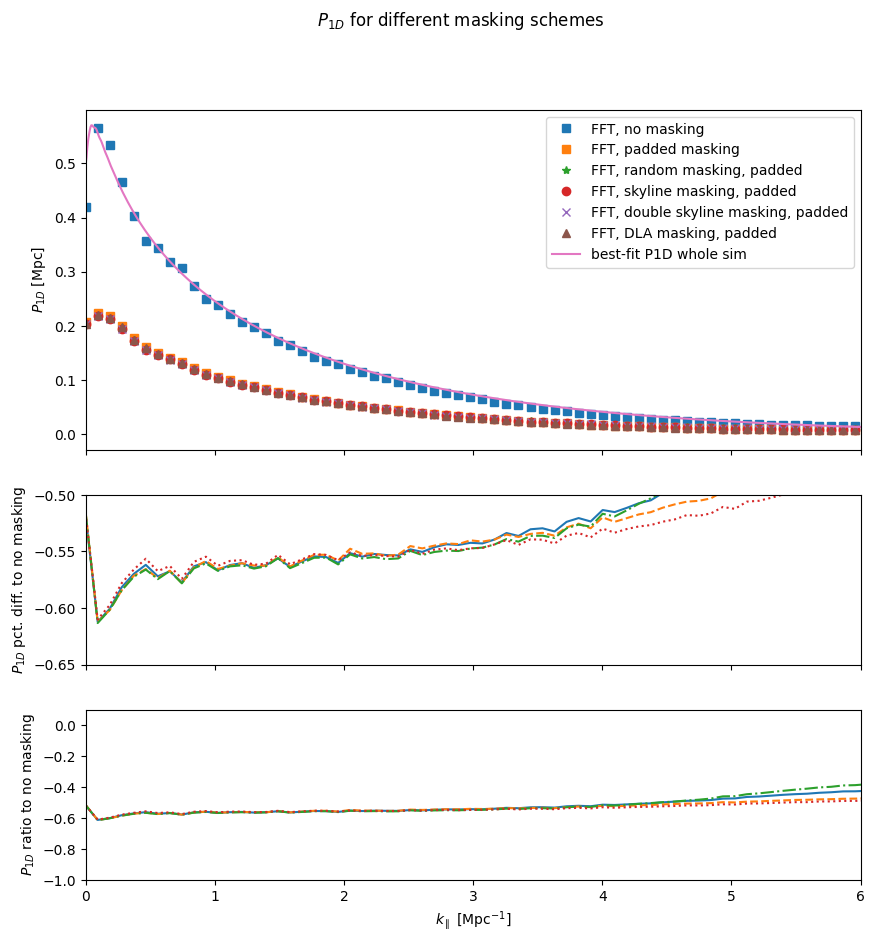

In [70]:

# make a three-panel figure with the lower panels smaller
fig, ax = plt.subplots(3, 1, figsize=[10, 10], gridspec_kw={'height_ratios': [2, 1, 1]}, sharex=True)
# fig, ax = plt.subplots(2, 1, figsize=[10, 10], gridspec_kw={'height_ratios': [2, 1]})

if pad:
    add_str = ", padded"
ax[0].plot(kpar_b, pk_avg/wk, 's', label='FFT, no masking')
if pad:
    ax[0].plot(kpar_b, pk_avg_padded/wk, 's', label='FFT, padded masking')
ax[0].plot(kpar_b, pk_randmasked_avg/wk, '*', label=f'FFT, random masking{add_str}')
ax[0].plot(kpar_b, pk_skyline_avg/wk, 'o', label=f'FFT, skyline masking{add_str}')
ax[0].plot(kpar_b, pk_2skyline_avg/wk, 'x', label=f'FFT, double skyline masking{add_str}')
ax[0].plot(kpar_b, pk_dla_avg/wk, '^', label=f'FFT, DLA masking{add_str}')

ax[0].plot(kfine, p1d_fine, label='best-fit P1D whole sim')


# plt.ylim([-1,1])
plt.suptitle(r"$P_{1D}$ for different masking schemes")
ax[0].set_xlim([0,6])
ax[1].set_xlim([0,6])
ax[0].legend()
ax[0].set_ylabel(r'$P_{1D}$ [Mpc]')

# plot the pct difference from no-masking in the lower panel
ax[1].plot(kpar_b, (pk_randmasked_avg)/pk_avg-1, linestyle='solid')
ax[1].plot(kpar_b, (pk_skyline_avg)/pk_avg-1, linestyle='dashed')
ax[1].plot(kpar_b, (pk_2skyline_avg)/pk_avg-1, linestyle='dashdot')
ax[1].plot(kpar_b, (pk_dla_avg)/pk_avg-1, linestyle='dotted')

ax[1].set_ylim([-0.65, -.5])
ax[1].set_ylabel(r'$P_{1D}$ pct. diff. to no masking')

# plot the ratio oin the last panel
ax[2].plot(kpar_b, (pk_randmasked_avg/pk_avg-1), linestyle='solid')
ax[2].plot(kpar_b, (pk_skyline_avg/pk_avg-1), linestyle='dashed')
ax[2].plot(kpar_b, (pk_2skyline_avg/pk_avg-1), linestyle='dashdot')
ax[2].plot(kpar_b, (pk_dla_avg/pk_avg-1), linestyle='dotted')

ax[2].set_xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]')
ax[2].set_ylabel(r'$P_{1D}$ ratio to no masking')
ax[2].set_ylim([-1, 0.1])


In [71]:
Ntest = 5000
pk_avg_test = np.ma.mean((delta_flux_k[:Ntest].__abs__())**2, axis=0)
pk_2skyline_test = np.ma.mean((delta_flux_2skyline_k[:Ntest].__abs__())**2, axis=0)
# apply the mask power to the nonmasked power
# flatten the fft mask array
skyline_2mask_k_flat = np.reshape(skyline_2mask_k, (nskew, Nk))[:Ntest] # only do the first corner of the box for testing

pk_2skyline_corrected = []
for m in range(len(pk_avg)): # for each Fourier mode
    print(m)
    pk_2skyline_corrected.append(mc.calculate_masked_power(m, skyline_2mask_k_flat, pk_avg_test))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67


(0.1, 6)

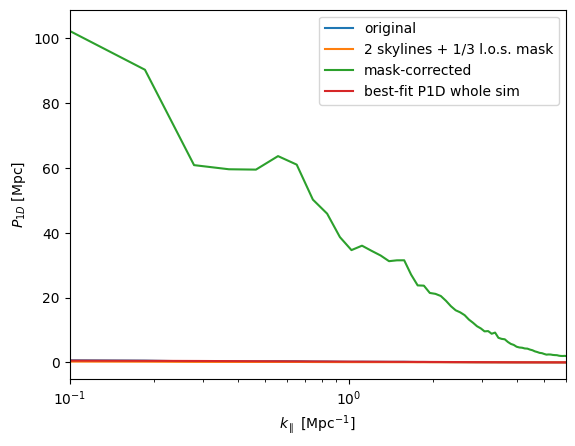

In [72]:
plt.plot(kpar_b, pk_avg_test, label='original')
plt.plot(kpar_b, pk_2skyline_test, label='2 skylines + 1/3 l.o.s. mask')
plt.plot(kpar_b, pk_2skyline_corrected, label='mask-corrected')
plt.plot(kfine, p1d_fine, label='best-fit P1D whole sim')

plt.legend()
plt.xscale('log')
plt.xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]')
plt.ylabel(r'$P_{1D}$ [Mpc]')
plt.xlim([.1,6])

In [59]:
print("Lowest k mode that can be measured with full box is ", kpar_b[1], 2*np.pi/L, "the fundamental frequency")

Lowest k mode that can be measured with full box is  0.09308422677303092 0.09308422677303091 the fundamental frequency


In [47]:
def get_pad_power(Np, pix_spacing, Npix_pad):
    # compute the power lost by the zero padding
    mask = np.ones(Np)
    mask[:int(Npix_pad//2)] = 0
    mask[int(-Npix_pad//2):] = 0
    mask_fft = np.fft.rfft(mask)*np.sqrt(pix_spacing/Np)
    power_pad = np.mean(mask_fft.__abs__())**2
    return power_pad

In [49]:
pad_power = get_pad_power(Np_b, pix_spacing_b, Np_b//2)
pad_power

0.033867994432682735

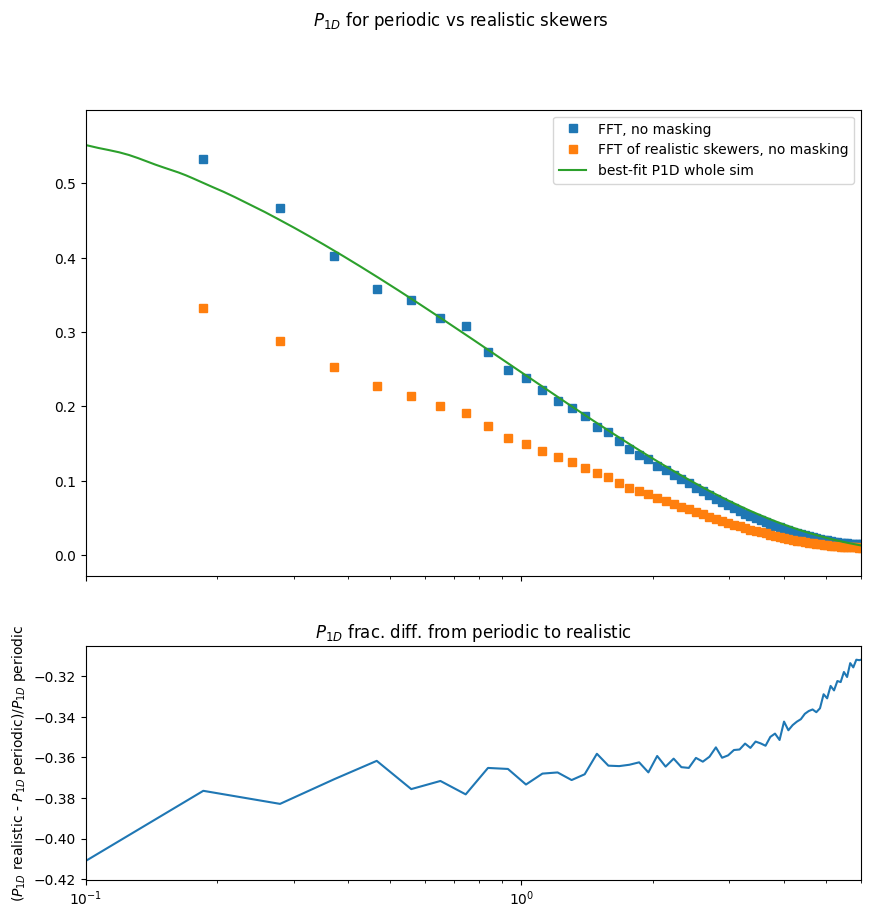

In [51]:

# make a three-panel figure with the lower panels smaller
fig, ax = plt.subplots(2, 1, figsize=[10, 10], gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
# fig, ax = plt.subplots(2, 1, figsize=[10, 10], gridspec_kw={'height_ratios': [2, 1]})

ax[0].plot(kpar_b, pk_avg/wk, 's', label='FFT, no masking')
ax[0].plot(kpar_b, pk_avg_r/wk, 's', label='FFT of realistic skewers, no masking')
ax[0].plot(kfine, p1d_fine, label='best-fit P1D whole sim')



plt.suptitle(r"$P_{1D}$ for periodic vs realistic skewers")
ax[0].set_xlim([0.1,6])
ax[1].set_xlim([0.1,6])
# set log scale
ax[0].set_xscale('log')
ax[0].legend()
# ax[0].set_ylabel(r'$P_{1D}$ [Mpc]')

# # plot the pct difference 
ax[1].plot(kpar_b, (pk_avg_r)/pk_avg-1, linestyle='solid')
# ax[1].plot(kpar_b_r, (pk_skyline_avg_r)/pk_avg_r-1, linestyle='dashed')
# ax[1].plot(kpar_b_r, (pk_2skyline_avg_r)/pk_avg_r-1, linestyle='dashdot')
# ax[1].plot(kpar_b_r, (pk_dla_avg_r)/pk_avg_r-1, linestyle='dotted')

# ax[1].set_ylim([-0.05, 0.05])
ax[1].set_title(r'$P_{1D}$ frac. diff. from periodic to realistic')
ax[1].set_ylabel(r'($P_{1D}$ realistic - $P_{1D}$ periodic)/$P_{1D}$ periodic')
ax[1].set_xscale('log')
# # plot the ratio oin the last panel
# ax[2].plot(kpar_b_r, (pk_randmasked_avg_r/pk_avg_r-1), linestyle='solid')
# ax[2].plot(kpar_b_r, (pk_skyline_avg_r/pk_avg_r-1), linestyle='dashed')
# ax[2].plot(kpar_b_r, (pk_2skyline_avg_r/pk_avg_r-1), linestyle='dashdot')
# ax[2].plot(kpar_b_r, (pk_dla_avg_r/pk_avg_r-1), linestyle='dotted')

# ax[2].set_xlabel(r'$k_{\parallel}$ [Mpc$^{-1}$]')
# ax[2].set_ylabel(r'$P_{1D}$ ratio to no masking')
